# Identification of organic compounds from their refractive index using deep learning

---
This notebook is for a model developed using Visible region data which is obtained after data augmentation (Synthesizing refractive index data) using the sellmeier equation



In [113]:
# Install keras
# !pip install keras==2.1.6

In [114]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

#New imports
# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# tf.keras.utils.to_categorical
%matplotlib inline

In [115]:
# Mounting google drive, to be able to write & read files on it
# This code block can only run on colab.research.google.com (Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing our uv_vis augmented data, currently using github hosted file.
This data is a result of data augmentation (Synthesizing refractive index data) using the sellmeier equation.

Data was increased from 1807 to 164375 rows


In [116]:
df = pd.read_csv("https://raw.githubusercontent.com/innokirigiti/mypublicfolder/main/uv_visAugmentedData.csv")
df.head()

,book,wl,n,k
0,6,0.742000,1.409560,0.000000e+00
1,8,0.589000,1.458588,0.000000e+00
2,18,0.616100,1.341224,0.000000e+00
3,22,0.519589,1.363940,8.136380e-08
4,11,0.544281,1.505436,2.598000e-03


# Data visualization and pre-processing

In [117]:
# Shape of the dataframe
df.shape

(164375, 4)

## One hot encoding targets (Classes of organic compounds) with integers

## Grouping data by wavelengths in 'UV' & 'Visible' in regions

In [118]:
# Shuffling data to make it random
df = df.sample(frac=1).reset_index(drop= True)
df.head()

,book,wl,n,k
0,51,0.602292,1.519193,0.0
1,59,0.033352,1.469514,0.0
2,52,0.673836,1.607691,0.0
3,5,0.674877,1.476489,0.0
4,20,0.625520,1.431588,0.0


In [119]:
# Describing the uv_vis data
df.describe()

,book,wl,n,k
count,164375.000000,164375.000000,164375.000000,164375.000000
mean,29.045469,0.382300,1.716884,0.000146
std,16.928166,0.214831,1.621956,0.008653
min,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.198094,1.404897,0.000000
50%,28.000000,0.386481,1.478450,0.000000
75%,43.000000,0.567966,1.594453,0.000000
max,59.000000,0.750000,46.395341,0.809000


In [120]:
# Classifying the wavelengths to different categories,based on the range of Wavelengths
df['wl_range'] = pd.cut(df['wl'], [0,0.4,np.inf], labels= ['UV', 'Visible'])
df.sample(3)

,book,wl,n,k,wl_range
158546,25,0.728409,1.395727,0.0,Visible
42734,24,0.416856,1.492326,0.0,Visible
59684,11,0.274560,1.571952,0.0,UV


Let’s see how many of each class is in our data set

In [121]:
df['wl_range'].value_counts()

UV         85167
Visible    79207
Name: wl_range, dtype: int64

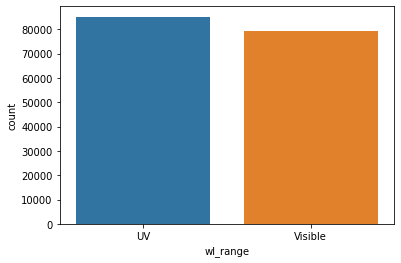

In [122]:
# Visualising
sns.countplot(x ='wl_range', data = df)

In [123]:
# Lets select only rows within Visible region
df = df.loc[df['wl_range'].isin(['Visible'])]
df.head()

,book,wl,n,k,wl_range
0,51,0.602292,1.519193,0.0,Visible
2,52,0.673836,1.607691,0.0,Visible
3,5,0.674877,1.476489,0.0,Visible
4,20,0.625520,1.431588,0.0,Visible
5,55,0.676988,1.322849,0.0,Visible


In [124]:
# Describe new df with only Visible region data
df.describe()

,book,wl,n,k
count,79207.000000,79207.000000,79207.000000,79207.000000
mean,28.912015,0.574542,1.431736,0.000008
std,16.949820,0.100703,0.147936,0.000142
min,0.000000,0.400001,0.884576,0.000000
25%,14.000000,0.487712,1.377841,0.000000
50%,28.000000,0.574476,1.443862,0.000000
75%,43.000000,0.661000,1.525289,0.000000
max,59.000000,0.750000,1.704342,0.003804


In [125]:
df.shape

(79207, 5)

## Feature selection/extraction
Creating predictors(X) and Targets(y) for Training and testing the Deep Learning model.

In [126]:
# Predictors / Features (X)
x = df.drop(['book', 'wl_range'], axis=1)

# Target (y)
y = df['book']   # Taget Vector

print('Shapes of Predictors & Targets')

print('Predictors (X): ', np.shape(x))
print('Targets (y): ', np.shape(y))

Shapes of Predictors & Targets
Predictors (X):  (79207, 3)
Targets (y):  (79207,)


## Normalizing Data


In [127]:
x_norm = (x - x.mean()) / x.std()
x_norm.sample(10)

,wl,n,k
38109,-0.040040,0.707225,-0.053401
16302,1.239914,-0.257000,-0.053401
147460,0.766239,-0.190519,-0.053401
34858,-0.796186,0.642547,-0.053401
21813,0.939063,0.108314,-0.053401
96838,-0.554106,1.140743,-0.053401
135754,1.184074,-0.741481,-0.053401
38485,-0.054068,0.087940,-0.053401
2386,1.437737,-0.747728,-0.053401
46229,-0.866033,-0.056594,-0.053401


# Train - Test data splitting 
`80%` for training and `20%` for testing



In [128]:
# split the data for training and testing
from sklearn.metrics import accuracy_score,classification_report
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size = 0.2,random_state=42)

In [129]:
print ('X - Train shape: ', x_train.shape)
print ('y - Train shape: ', y_train.shape)

print ('X - Test shape: ', x_test.shape)
print ('y - Test shape: ', y_test.shape)

X - Train shape:  (63365, 3)
y - Train shape:  (63365,)
X - Test shape:  (15842, 3)
y - Test shape:  (15842,)


In [130]:
# Converting our target into categorical
# (one hot encode outputs)
# The output of each prediction will be the 60 probalilities of corresponding 
# classes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_test.shape[1]
print(num_classes)

60


In [131]:
# Building DL Classifier
# define classification model
def classification_model():
    # create model
    model = keras.Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=(3,)))
    model.add(layers.Dense(100, activation='relu'))

    model.add(layers.Dense(num_classes, activation='softmax'))
 
    # compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# build the model
model = classification_model()
epochs = 300

In [132]:
# Model Summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 50)                200       
                                                                 
 dense_16 (Dense)            (None, 100)               5100      
                                                                 
 dense_17 (Dense)            (None, 60)                6060      
                                                                 
Total params: 11,360
Trainable params: 11,360
Non-trainable params: 0
_________________________________________________________________


In [133]:
# Train, validate & test
# We are removing 30% of data from training set as Validation set
# & Fitting the model (Training)
history = model.fit(x_train, y_train, validation_split = 0.3, epochs = epochs, verbose=2)

Epoch 1/300
1387/1387 - 4s - loss: 2.2834 - accuracy: 0.2498 - val_loss: 1.6891 - val_accuracy: 0.3546 - 4s/epoch - 3ms/step
Epoch 2/300
1387/1387 - 3s - loss: 1.5020 - accuracy: 0.4312 - val_loss: 1.3728 - val_accuracy: 0.5119 - 3s/epoch - 2ms/step
Epoch 3/300
1387/1387 - 3s - loss: 1.2752 - accuracy: 0.5059 - val_loss: 1.1938 - val_accuracy: 0.5002 - 3s/epoch - 2ms/step
Epoch 4/300
1387/1387 - 3s - loss: 1.1439 - accuracy: 0.5531 - val_loss: 1.0772 - val_accuracy: 0.5543 - 3s/epoch - 2ms/step
Epoch 5/300
1387/1387 - 3s - loss: 1.0533 - accuracy: 0.5842 - val_loss: 1.0393 - val_accuracy: 0.5940 - 3s/epoch - 2ms/step
Epoch 6/300
1387/1387 - 3s - loss: 0.9807 - accuracy: 0.6101 - val_loss: 0.9636 - val_accuracy: 0.6030 - 3s/epoch - 2ms/step
Epoch 7/300
1387/1387 - 3s - loss: 0.9327 - accuracy: 0.6220 - val_loss: 0.9448 - val_accuracy: 0.6052 - 3s/epoch - 2ms/step
Epoch 8/300
1387/1387 - 3s - loss: 0.8909 - accuracy: 0.6337 - val_loss: 0.8399 - val_accuracy: 0.6534 - 3s/epoch - 2ms/step


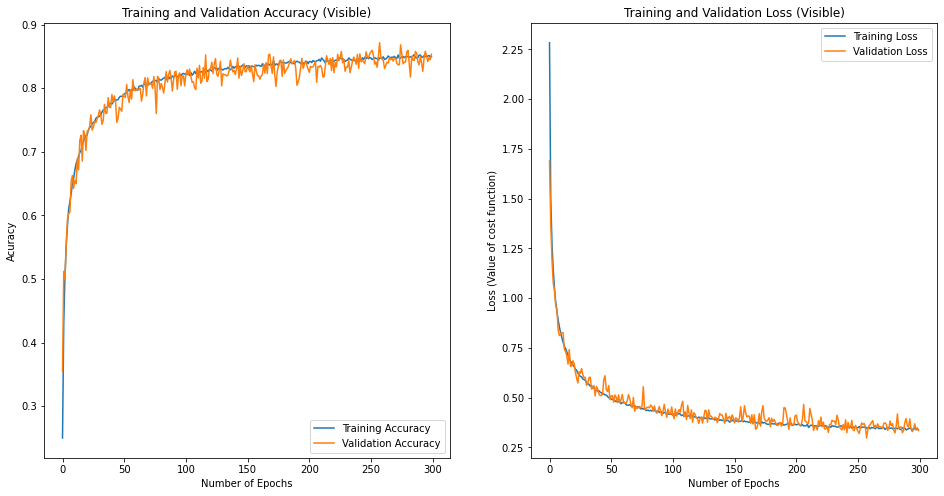

In [139]:
# Visualizing results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Visible)')
plt.ylabel('Acuracy')
plt.xlabel('Number of Epochs')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Visible)')
plt.ylabel('Loss (Value of cost function)')
plt.xlabel('Number of Epochs')
plt.show()

In [135]:
# # Save model as h5 (keras model) - 84.97 Accuracy
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/Aug_Vis_organic_model.h5')

In [136]:
# # Save the entire model as a SavedModel in drive - 84.97 Accuracy
# model.save('/content/drive/MyDrive/colab_data/DLOrganicClassifierData/SavedModels/Aug_Vis_organic_model') 

# Model Evaluation

In [140]:
# Model Accuracy
scores = model.evaluate(x_test, y_test, verbose=0)
print('The test Accuracy is: ', scores[1])
print('The test Loss is: ', scores[0])

The test Accuracy is:  0.8541219830513
The test Loss is:  0.3485288619995117


In [141]:
# Classification report
y_pred = model.predict(x_test) # Whole test set

predicted_categories = np.argmax(y_pred, axis=1) 
true_categories_argmax = np.argmax(y_test, axis=1)

print(classification_report(true_categories_argmax, predicted_categories))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       303
           1       1.00      0.80      0.89       285
           3       0.94      0.83      0.88       300
           5       0.99      0.91      0.95       359
           6       0.75      0.84      0.79       512
           7       0.91      0.99      0.95       294
           8       0.85      0.91      0.87       328
           9       0.86      0.97      0.91       353
          10       0.97      1.00      0.98       315
          11       0.97      0.95      0.96       356
          13       0.81      1.00      0.89       305
          14       0.85      0.99      0.92       320
          15       0.97      0.93      0.95       290
          17       0.31      0.26      0.29       344
          18       0.90      0.90      0.90       310
          19       0.00      0.00      0.00       329
          20       0.94      0.92      0.93       365
          21       0.84    